# Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# Read Images

In [2]:
def preprocess_name(imgpath, label):
    imgname = imgpath.split(".")[0]
    if label == "1":
        return imgname+"_p"
    else:
        return imgname+"_n"

def read_images(csvdir):
    with open(csvdir, newline="") as csvfile:
        imgs = dict()
        reader = csv.DictReader(csvfile)
        pcount = 0
        ncount = 0
        for row in reader:
            img_name = preprocess_name(row["ImagePath"].split("/")[-1], row["Labels"])
            bgr_img = cv2.imread(row["ImagePath"], cv2.IMREAD_UNCHANGED)
            imgs[img_name] = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        
        return imgs

In [3]:
IMAGES_CSV = r"../selected_dataset.csv"

In [4]:
images = read_images(IMAGES_CSV)

# Histogram Matching

In [5]:
from skimage.exposure import match_histograms

In [6]:
ref_img = r"/home/tsdhrm/Pictures/trials/KAGGLE_RETINA/ORIGA/Images_Cropped/353.jpg"
reference_bgr = cv2.imread(ref_img, cv2.IMREAD_UNCHANGED)
reference = cv2.cvtColor(reference_bgr, cv2.COLOR_BGR2RGB)

In [7]:
matched = dict()

for image in images:
    matched[image] = match_histograms(images[image], reference, channel_axis=-1)

# Display

In [8]:
def display_all(imgs, subs=(84,4), fgsz=(5,130), use_gray=False):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k], 'gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def display_all_with(imgs, cc, subs=(84,4), fgsz=(5,170), use_gray=True):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k][:,:,cc], cmap='gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def save_plots(imgs, suptitle, savedir, subs=(84,4), fgsz=(5,170), use_gray=False):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k], 'gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
    fig.suptitle(suptitle)
    fig.savefig(savedir)
    print(f'Figure is successfully saved at {savedir}')
    
def display_all_histo(imgs, subs=(84,4), fgsz=(5,170)):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            # print(list(imgs.values())[k])
            sample_histo = cv2.calcHist([list(imgs.values())[k]],[0],None,[256],[0,256]) 
            axs[i, j].plot(sample_histo)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1

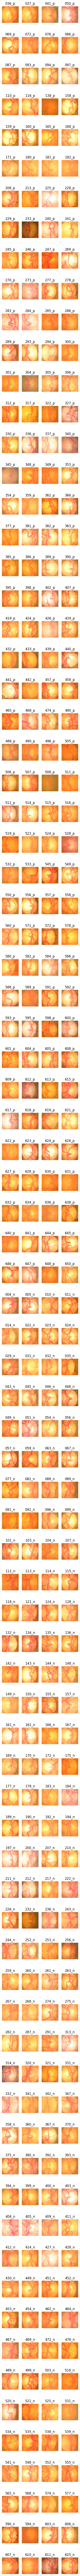

In [9]:
display_all(images, (84, 4), (5,170))

# Blood Vessel Removal

In [10]:
def remove_vessel(gray_img):
    circular_SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))
    opening_SE = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    neg = cv2.bitwise_not(gray_img)
    top_hat = cv2.morphologyEx(neg, cv2.MORPH_TOPHAT, circular_SE)
    clahe_base = cv2.createCLAHE(2, (8,8))
    clahed = clahe_base.apply(top_hat)
    ret, th = cv2.threshold(clahed, 10, 255, cv2.THRESH_BINARY)
    return th
    
    # clahe_f = cv2.createCLAHE(2, (8,8))
    # clahed = clahe_f.apply(gray_img)
    # blurred = cv2.GaussianBlur(clahed, (5,5), 0)
    # return blurred

In [11]:
def clear_vessel(imgs: dict):
    novessel = dict()
    for img in imgs:
        # hsv = cv2.cvtColor(imgs[img], cv2.COLOR_RGB2HSV)
        # screen[img] = imgs[img][:,:,1]
        # gray = cv2.cvtColor(imgs[img], cv2.COLOR_RGB2GRAY)
        bloodvsl = remove_vessel(imgs[img][:,:,1])# was using green
        novessel[img] = cv2.inpaint(imgs[img], bloodvsl, 7, cv2.INPAINT_TELEA)
        
    return novessel

In [12]:
no_vsl = clear_vessel(matched)

# Segmentation

## OC Segmentation

In [13]:
from skimage.segmentation import flood, flood_fill

In [14]:
def correct_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0,256)]).astype("uint8")
    return cv2.LUT(image, table)

In [15]:
def segment_oc(novessel):
    screen = dict()
    
    for vsl in novessel:
        green = novessel[vsl][:,:,1]
        gmc = correct_gamma(green, 0.5)
        ret, screen[vsl] = cv2.threshold(gmc, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
    display_all(screen, use_gray=True)
    return None, None

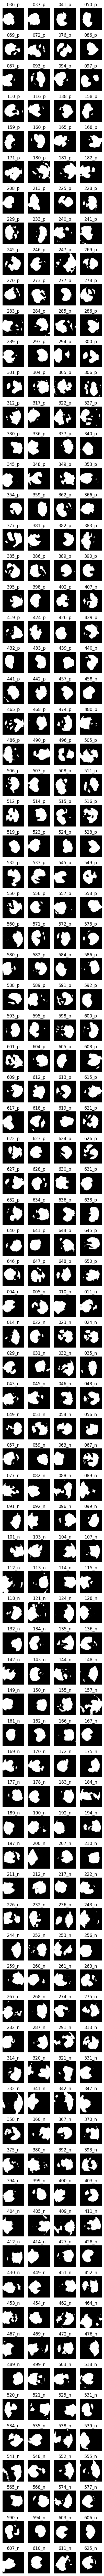

In [16]:
oc_lines, oc_binaries = segment_oc(no_vsl)